In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib import rc


font = {'family': 'Droid Sans'}
rc('font', **font)

In [2]:
tr = pd.read_csv('./Data/train.csv')
te = pd.read_csv('./Data/test.csv')
# will not make features for the smallest class with ~5 elements
tr = tr[tr.TripType != 14]

In [3]:
visits = tr.drop_duplicates('VisitNumber')[['VisitNumber', 'TripType']]
a = StratifiedShuffleSplit(visits['TripType'], n_iter = 1, test_size =0.3, random_state = 2222)
tr, te = (tr[tr.VisitNumber.isin(visits.iloc[list(a)[0][0]]['VisitNumber'])],
          tr[tr.VisitNumber.isin(visits.iloc[list(a)[0][1]]['VisitNumber'])])

# TF-IDF features

In [4]:
feature = 'FinelineNumber'
# feature = 'DepartmentDescription'
# feature = 'Upc'
counts = tr[feature].append(te[feature]).value_counts()

In [5]:
restriction = set(tr[feature].unique()).intersection(set(te[feature].unique()))

In [6]:
count_thr = 1
def foo(x,feature):
    l = ''
    for t, row in x.iterrows():
        l += (str(row[feature]).replace(' ','').replace(',','') + ' ') * row['ScanCount'] 
    return l
sentences_tr = tr[(tr[feature].isin(counts[counts>count_thr].index)) & 
                 (tr[feature].isin(restriction))].groupby('VisitNumber').apply(lambda x: foo(x, feature))
sentences_te = te[(te[feature].isin(counts[counts>count_thr].index)) &
                 (te[feature].isin(restriction))].groupby('VisitNumber').apply(lambda x: foo(x, feature))
temp_tr = tr[(tr[feature].isin(counts[counts>count_thr].index)) & 
                 (tr[feature].isin(restriction))].drop_duplicates('VisitNumber').reset_index(drop=True)
temp_te = te[(te[feature].isin(counts[counts>count_thr].index)) &
                 (te[feature].isin(restriction))].drop_duplicates('VisitNumber').reset_index(drop=True)

In [7]:
tt = TfidfTransformer()
cv = CountVectorizer()
cv.fit(sentences_tr.append(sentences_te))
counts_tr = cv.transform(sentences_tr)
counts_te = cv.transform(sentences_te)
counts_all = cv.transform(sentences_tr.append(sentences_te))
tt.fit(counts_all)
tfidf_tr = tt.transform(counts_tr)
tfidf_te = tt.transform(counts_te)

# Stratified k-fold nearest neighbours with tf-idf features

In [8]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import NearestNeighbors
nn_folds = StratifiedKFold(temp_tr['TripType'], n_folds=4, shuffle=True, random_state=406)
nn = NearestNeighbors(4, metric = 'cosine', algorithm = 'brute')
features_tr = temp_tr['VisitNumber'].to_frame().copy()
features_te = temp_te['VisitNumber'].to_frame().copy()
for train_index, test_index in nn_folds:
    for i in sorted(temp_tr.TripType.unique()):
        if i != 14:
            nn.fit(tfidf_tr[temp_tr.loc[train_index][temp_tr.TripType == i].index])
            features_tr.loc[test_index, feature + '_distance_to_' + str(i)] = np.mean(nn.kneighbors(tfidf_tr[test_index])[0][:, 2:5], axis = 1)
        else:
            nn = NearestNeighbors(2, metric = 'cosine', algorithm = 'brute')
            nn.fit(tfidf_tr[temp_tr.loc[train_index][temp_tr.TripType == i].index])
            features_tr.loc[test_index, feature + '_distance_to_' + str(i)] = nn.kneighbors(tfidf_tr[test_index])[0][:, 1]
            nn = NearestNeighbors(4, metric = 'cosine', algorithm = 'brute')
            
for i in sorted(temp_tr.TripType.unique()):
    nn.fit(tfidf_tr[temp_tr[temp_tr.TripType == i].index])
    if i == 14:
        nn = NearestNeighbors(3, metric = 'cosine', algorithm = 'brute')
        nn.fit(tfidf_tr[temp_tr[temp_tr.TripType == i].index])
        features_te.loc[:, feature + '_distance_to_' + str(i)] = nn.kneighbors(tfidf_te)[0][:, 1]
        nn = NearestNeighbors(4, metric = 'cosine', algorithm = 'brute')
    else:
        features_te.loc[:, feature + '_distance_to_' + str(i)] = np.mean(nn.kneighbors(tfidf_te)[0][:, 2:5], axis = 1)

/opt/conda/Anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=4.
  % (min_labels, self.n_folds)), Warning)
/opt/conda/Anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [ ]:
# Compare feature in train and test
(features_tr.mean() - features_te.mean()).iloc[1:].describe()

# Make nice picture with distances

In [11]:
# Расчет расстояний для картинки
l = list()
for j in sorted(temp_tr.TripType.unique()):
    if j != 14:
        nn = NearestNeighbors(4, metric = 'cosine', algorithm = 'brute')
        nn.fit(tfidf_tr[temp_tr[temp_tr.TripType == j].index])
        qq = nn.kneighbors(tfidf_te)[0]
        temp = list()

        for i in sorted(temp_tr.TripType.unique()):
            if i != 14:
                temp.append(np.mean(qq[:, 3:5][temp_te[temp_te.TripType == i].index]))
        l.append(temp)

In [12]:
%matplotlib inline

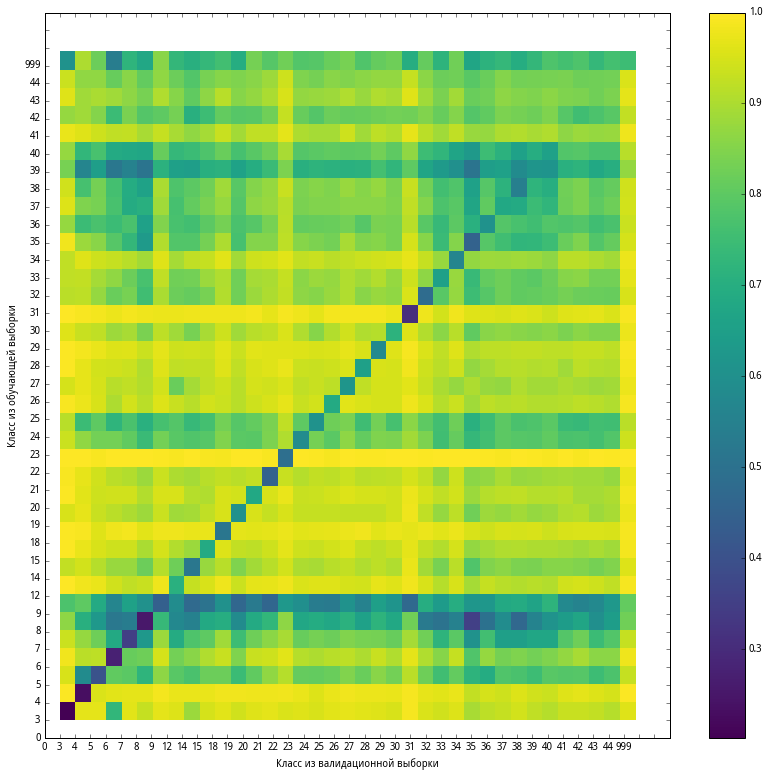

In [13]:
# Thanks Stackoverflow
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
fig, ax  = plt.subplots(figsize=(14,13))
x = np.array(list(range(1,39)))*1.021
y = np.array(list(range(1,39)))*1.021
x, y = np.meshgrid(x, y)
l = np.array(l)
plt.xlim([0, 41])
plt.ylim([0, 41])
plt.pcolormesh(x, y, l, cmap = 'viridis')
plt.colorbar() 
ax.xaxis.set_major_locator(MaxNLocator(41))
ax.yaxis.set_major_locator(MaxNLocator(41))
plt.ylabel('Класс из обучающей выборки')
plt.xlabel('Класс из валидационной выборки')
ax.set_xticklabels([0]+sorted(temp_tr.TripType.unique()))
ax.set_yticklabels([0]+sorted(temp_tr.TripType.unique()))
plt.show() #boom

Back-up features

In [9]:
features_tr.to_pickle('./Data/tfidif_tr_val')
features_te.to_pickle('./Data/tfidif_te_val')

In [7]:
features_tr = pd.read_pickle('./Data/tfidif_tr_val')
features_te = pd.read_pickle('./Data/tfidif_te_val')

# Some scikit learn interface classifier features
Not optimal, but works well for me

In [21]:
# Для риджа нужны тф-идф фичи и файлы с номерами походов в магазины
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
num_folds = 9

nn_ridge = StratifiedKFold(temp_tr['TripType'], n_folds=num_folds, shuffle=True, random_state=406)
# rr = RidgeClassifier(alpha=1., fit_intercept=True, 
#                       normalize=True, 
#                       copy_X=True, max_iter=None, 
#                       tol=0.00001, class_weight=None, solver='auto')
rr = SGDClassifier(loss='log', 
                   penalty='l2', 
                   alpha=0.000001, 
                   l1_ratio=0.15,
                   fit_intercept=True, 
                   n_iter=50, 
                   shuffle=True, 
                   verbose=0, 
                   epsilon=0.1, 
                   n_jobs=-1, 
                   random_state=None, 
                   learning_rate='optimal', 
                   eta0=0.0, 
                   power_t=0.5, 
                   class_weight=None, 
                   warm_start=False, 
                   average=True)
features_ridge = ['Ridge_'+str(x) for x in sorted(tr.TripType.unique())]
for i in features_ridge:
    temp_tr.loc[:, i] = 0
    temp_te.loc[:, i] = 0
qq = 1
for train_index, test_index in nn_ridge:
    rr.fit(tfidf_tr[train_index],temp_tr.iloc[train_index]['TripType'])
    d = rr.decision_function(tfidf_tr[test_index])
    probs_train = np.exp(d) / (1 + np.exp(d))
    for i in range(len(features_ridge)):
        temp_tr.loc[:, features_ridge[i]].iloc[test_index] = probs_train[:,i]
    d = rr.decision_function(tfidf_te)
    probs = np.exp(d) / (1 + np.exp(d))
    temp_te.loc[:, features_ridge] += probs
    print('Iteration {0}, validation loss - {1}, train loss {2}'.format(qq,
                                                                        log_loss(temp_te['TripType'], probs),
                                                                        log_loss(temp_tr.iloc[test_index]['TripType'], probs_train)))
    qq += 1

print('Final validation loss {0}'.format(log_loss(temp_te['TripType'], temp_te.loc[:, features_ridge].as_matrix() )))
features_ridge_tr = temp_tr[features_ridge+['VisitNumber']].copy()
features_ridge_te = temp_te[features_ridge+['VisitNumber']].copy()

cols_ridge = list(features_ridge_tr.columns)
cols_ridge.remove('VisitNumber')
qq = np.sum(features_ridge_tr[cols_ridge].as_matrix(),axis = 1)
features_ridge_tr.loc[:,cols_ridge] = features_ridge_tr[cols_ridge].apply(lambda x: x/qq, axis = 0)
qq = np.sum(features_ridge_te[cols_ridge].as_matrix(),axis = 1)
features_ridge_te.loc[:,cols_ridge] = features_ridge_te[cols_ridge].apply(lambda x: x/qq, axis = 0)

Iteration 1, validation loss - 1.6071302374981655, train loss 1.6123224103832878
Iteration 2, validation loss - 1.6027233747474854, train loss 1.603007188913984
Iteration 3, validation loss - 1.6080150362155963, train loss 1.6465023085871688
Iteration 4, validation loss - 1.6064407283975186, train loss 1.6189416683148155
Iteration 5, validation loss - 1.6053827743666846, train loss 1.6435493641741055
Iteration 6, validation loss - 1.6050867669953894, train loss 1.591081239408098
Iteration 7, validation loss - 1.6103098271666045, train loss 1.6237653294400807
Iteration 8, validation loss - 1.606346368815508, train loss 1.616896307740524
Iteration 9, validation loss - 1.6034838440629056, train loss 1.5956936405754683
Final validation loss 1.7439213099818915


/opt/conda/Anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# KNN classifier features. 
different cell, from what was above, because of memory problems in scikit learn KNN

In [67]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold

In [68]:
rr = xgb.XGBClassifier(max_depth=130, 
                       learning_rate=0.5, 
                       n_estimators=5, 
                       silent=True, 
                       objective='multi:softprob', 
                       nthread=-1, 
                       gamma=0, 
                       min_child_weight=1, 
                       max_delta_step=0, 
                       subsample=1, 
                       colsample_bytree=0.8, 
                       base_score=0.027, 
                       seed=0, missing=None)

In [9]:
tfidf_te = tfidf_te.todense()
tfidf_tr = tfidf_tr.todense()

In [10]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import xgboost as xgb

num_folds = 7
num_nn = 2
num_test_parts = 10

nn_ridge = StratifiedKFold(temp_tr['TripType'], n_folds=num_folds, shuffle=True, random_state=406)
# rr = KNeighborsClassifier(n_neighbors=num_nn, 
#                                        algorithm='brute', 
#                                        metric='cosine', n_jobs=-1)
features_knn = ['KNN_'+str(x) for x in sorted(tr.TripType.unique())]
# Создаю столбцы
for i in features_knn:
    temp_tr.loc[:, i] = 0
    temp_te.loc[:, i] = 0

qq = 1
for train_index, test_index in nn_ridge:
    print('Fold {0}'.format(qq))
    qq += 1
    rr.fit(tfidf_tr[train_index],temp_tr.iloc[train_index]['TripType'])
    d = rr.predict_proba(tfidf_tr[test_index])
    # Очередной тупняк пандаса, который не хочет присваивать сразу набору столбцов значение, поэтому цикл
    for i in range(len(features_knn)):
        temp_tr.loc[:, features_knn[i]].iloc[test_index] = d[:,i]
    # Почему-то кнн не хочет предсказывать для большого теста результат. Разделю тест на n частей
    batch_size = int(tfidf_te.shape[0]/num_test_parts)
    for i in range(num_test_parts):
        if i!=(num_test_parts-1):
            ind = range(batch_size*i, batch_size*(i+1))
        else: ind = range(batch_size*i, tfidf_te.shape[0])
        d = rr.predict_proba(tfidf_te[ind])
        for i in range(len(features_knn)):
            temp_te.loc[:, features_knn[i]].iloc[ind] += d[:,i]

features_knn_tr = temp_tr[features_knn+['VisitNumber']].copy()
features_knn_te = temp_te[features_knn+['VisitNumber']].copy()
cols_knn= list(features_knn_tr.columns)
cols_knn.remove('VisitNumber')
qq = np.sum(features_knn_tr[cols_knn].as_matrix(),axis = 1)
features_knn_tr.loc[:,cols_knn] = features_knn_tr[cols_knn].apply(lambda x: x/qq, axis = 0)
qq = np.sum(features_knn_te[cols_knn].as_matrix(),axis = 1)
features_knn_te.loc[:,cols_knn] = features_knn_te[cols_knn].apply(lambda x: x/qq, axis = 0)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
CPU times: user 5min 49s, sys: 3min 41s, total: 9min 30s
Wall time: 9min 30s


/opt/conda/Anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
tfidf_te.shape

(20985, 5323)

## Back-up some features

In [10]:
features_ridge_tr.to_pickle('ridge_features_tr_val_9')
features_ridge_te.to_pickle('ridge_features_te_val_9')

In [71]:
features_ridge_tr.to_pickle('ridge_features_tr_val_9_depdesk')
features_ridge_te.to_pickle('ridge_features_te_val_9_depdesk')

In [79]:
features_ridge_tr.to_pickle('ridge_features_tr_val_9_upc')
features_ridge_te.to_pickle('ridge_features_te_val_9_upc')

In [43]:
features_knn_tr.to_pickle('knn_features_tr_val_7_25n')
features_knn_te.to_pickle('knn_features_te_val_7_25n')

In [84]:
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9')

In [11]:
features_knn_tr = pd.read_pickle('knn_features_tr_val_9_20n')
features_knn_te = pd.read_pickle('knn_features_te_val_9_20n')

In [87]:
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9_depdesk')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9_depdesk')

In [89]:
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9_upc')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9_upc')

In [40]:
features_tr.to_pickle('distance_features_tr_val_35n')
features_te.to_pickle('distance_features_te_val_25n')

NameError: name 'features_tr' is not defined

In [22]:
features_tr= pd.read_pickle('distance_features_tr_val_35n')
features_te=pd.read_pickle('distance_features_te_val_25n')

# Read data from pickle

In [9]:
# Для паблика
tr = pd.read_pickle('./Data/tr_aggregates')
te = pd.read_pickle('./Data/te_aggregates')

In [23]:
# Вытаскиваем из трейна валидацию
train = pd.read_pickle('./Data/tr_aggregates')
tr, te = (train[train.VisitNumber.isin(visits.iloc[list(a)[0][0]]['VisitNumber'])],
          train[train.VisitNumber.isin(visits.iloc[list(a)[0][1]]['VisitNumber'])])

In [15]:
tr = tr.merge(features_tr, how = 'left', on = 'VisitNumber').fillna(1)
te = te.merge(features_te, how = 'left', on = 'VisitNumber').fillna(1)
# tr = tr.merge(features_knn_tr, how = 'left', on = 'VisitNumber').fillna(0)
# te = te.merge(features_knn_te, how = 'left', on = 'VisitNumber').fillna(0)
tr = tr.merge(features_ridge_tr, how = 'left', on = 'VisitNumber').fillna(0)
te = te.merge(features_ridge_te, how = 'left', on = 'VisitNumber').fillna(0)

In [24]:
# 3 набора фичей риджа
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9')
tr = tr.merge(features_ridge_tr, how = 'left', on = 'VisitNumber').fillna(0)
te = te.merge(features_ridge_te, how = 'left', on = 'VisitNumber').fillna(0)
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9_depdesk')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9_depdesk')
tr = tr.merge(features_ridge_tr, how = 'left', on = 'VisitNumber').fillna(0)
te = te.merge(features_ridge_te, how = 'left', on = 'VisitNumber').fillna(0)
features_ridge_tr = pd.read_pickle('ridge_features_tr_val_9_upc')
features_ridge_te = pd.read_pickle('ridge_features_te_val_9_upc')
tr = tr.merge(features_ridge_tr, how = 'left', on = 'VisitNumber').fillna(0)
te = te.merge(features_ridge_te, how = 'left', on = 'VisitNumber').fillna(0)

In [74]:
tfidf_tr

<66863x75 sparse matrix of type '<class 'numpy.float64'>'
	with 241615 stored elements in Compressed Sparse Row format>

In [98]:
tr.to_pickle('./Data/best_set_tr_val')
te.to_pickle('./Data/best_set_te_val')

In [83]:
tr = pd.read_pickle('./Data/best_set_tr_val')
te = pd.read_pickle('./Data/best_set_te_val')

# XGBoost

In [25]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_types = LabelEncoder()
le_types.fit(tr['TripType'].append(te['TripType']))
tr.loc[:, 'TripType'] = le_types.transform(tr['TripType'])
te.loc[:, 'TripType'] = le_types.transform(te['TripType'])

In [26]:
params = {"objective": "multi:softprob", 
          "eta": 0.06,
          "max_depth": 6,
          "subsample": 0.65,
          "colsample_bytree": 0.7,
          "silent": 1,
          'min_child_weight': 4,
          'num_class':38,
          'eval_metric': 'mlogloss',
          'nthread':3,
          'seed':7742
          }
ntrees = 400

In [27]:
dtrain = xgb.DMatrix(tr.drop(labels = ['TripType', 'VisitNumber'], axis = 1), label = tr['TripType'])
dvalid = xgb.DMatrix(te.drop(labels = ['TripType', 'VisitNumber'], axis = 1), label = te['TripType'])
# dtest = xgb.DMatrix(te.drop(labels = ['VisitNumber'], axis = 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

In [54]:
%%time
clf = xgb.train(params, 
              dtrain, 
                ntrees, 
                evals=watchlist
               )

[0]	eval-mlogloss:2.999000	train-mlogloss:2.992153
[1]	eval-mlogloss:2.701854	train-mlogloss:2.689327
[2]	eval-mlogloss:2.482360	train-mlogloss:2.463699
[3]	eval-mlogloss:2.312747	train-mlogloss:2.288756
[4]	eval-mlogloss:2.173299	train-mlogloss:2.144017
[5]	eval-mlogloss:2.055804	train-mlogloss:2.021454
[6]	eval-mlogloss:1.952637	train-mlogloss:1.913763
[7]	eval-mlogloss:1.861657	train-mlogloss:1.818047
[8]	eval-mlogloss:1.781035	train-mlogloss:1.733462
[9]	eval-mlogloss:1.707933	train-mlogloss:1.656806
[10]	eval-mlogloss:1.641513	train-mlogloss:1.586997
[11]	eval-mlogloss:1.580833	train-mlogloss:1.523162
[12]	eval-mlogloss:1.525901	train-mlogloss:1.464619
[13]	eval-mlogloss:1.475739	train-mlogloss:1.411116
[14]	eval-mlogloss:1.429320	train-mlogloss:1.361097
[15]	eval-mlogloss:1.385964	train-mlogloss:1.314663
[16]	eval-mlogloss:1.345923	train-mlogloss:1.271692
[17]	eval-mlogloss:1.307962	train-mlogloss:1.230779
[18]	eval-mlogloss:1.272931	train-mlogloss:1.193126
[19]	eval-mlogloss:1.2

KeyboardInterrupt: 

### if you need to make average prediction

In [ ]:
from sklearn.metrics import log_loss
# ave = True
for i in range(4):
    params = {"objective": "multi:softprob", 
              "eta": 0.06,
              "max_depth": 6,
              "subsample": 0.65,
              "colsample_bytree": 0.7,
              "silent": 1,
              'min_child_weight': 4,
              'num_class':38,
              'eval_metric': 'mlogloss',
              'nthread':3,
              'seed':7742
              }
    clf = xgb.train(params, 
                    dtrain, 
                    ntrees, 
#                     evals=watchlist
                   )
    pred = clf.predict(dtest)
#     pred_train = clf.predict(dtrain)
    if type(ave) == bool:
        ave = pred.copy()
    else:
        ave += pred
#     print('Validation loss: {0}, train loss: {1}'.format(log_loss(te['TripType'], pred), log_loss(tr['TripType'], pred_train)))
# print('Average prediction loss {0}'.format(log_loss(te['TripType'], ave/15.)))

In [18]:
from sklearn.metrics import log_loss
print('Validation loss: {0}, train loss: {1}'.format(log_loss(te['TripType'], pred), log_loss(tr['TripType'], pred_train)))

Validation loss: 0.7428016404853823, train loss: 0.31202338004996805


In [18]:
pred = clf.predict(dtrain)

In [15]:
from sklearn.metrics import log_loss
# log_loss(tr['TripType'], pred)

In [98]:
pred = clf.predict(dvalid)
log_loss(te['TripType'], pred)

0.83126021368876035

# RF feature importance

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf = RandomForestClassifier(n_estimators=400, 
                             criterion='gini', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=10, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=0.5, 
                             max_leaf_nodes=None, 
                             bootstrap=True, 
                             oob_score=False, 
                             n_jobs=-1, 
                             random_state=4222, 
                             verbose=0, 
                             warm_start=False, 
                             class_weight=None)

In [18]:
rf.fit(tr.drop(labels = ['TripType', 'VisitNumber'], axis = 1), tr['TripType'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=4222, verbose=0,
            warm_start=False)

In [19]:
pred = rf.predict_proba(te.drop(labels = ['TripType', 'VisitNumber'], axis = 1))
print(log_loss(te['TripType'], pred))
pred = rf.predict_proba(tr.drop(labels = ['TripType', 'VisitNumber'], axis = 1))
print(log_loss(tr['TripType'], pred))

1.83551292437
1.81207197284


In [21]:
features = list(te.drop(labels = ['TripType', 'VisitNumber'], axis = 1).columns)

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), features[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), indices)
plt.xlim([-1, len(features)])
plt.show()

# XGBoost Feature Importance

In [23]:
%matplotlib inline

/opt/conda/Anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


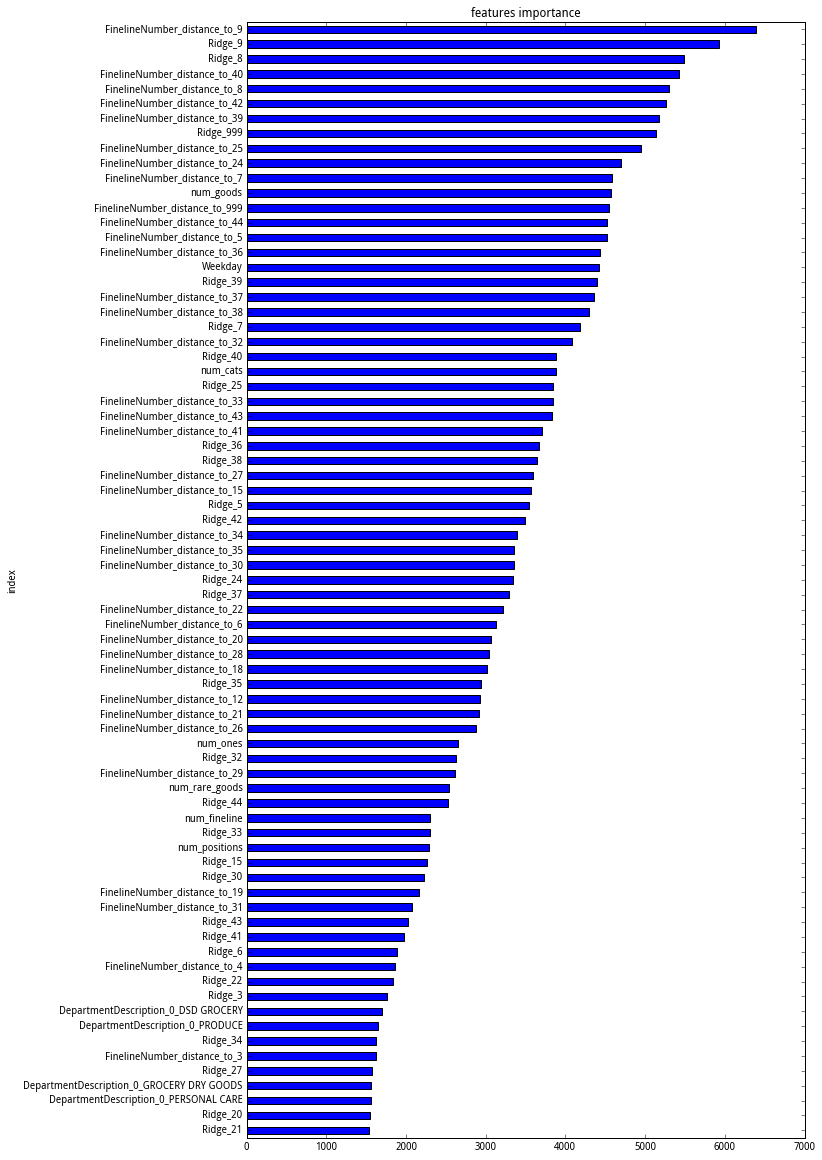

In [24]:
features = tr.drop(labels = ['TripType', 'VisitNumber'], axis = 1).columns
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(clf.get_fscore())
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-75:].plot(kind="barh", title=("features importance"), figsize = (10,20))

# Create file for Kaggle

In [ ]:
pred = clf.predict(dtest)
pred_df = pd.DataFrame(pred, columns = ['TripType_' + str(i) for i in le_types.inverse_transform(np.arange(38))])
pred_df.insert(0, 'VisitNumber', te.VisitNumber)
pred_df.to_csv('./Submissions/XGB_fineline_distances_ridge_4500.csv', index=False)

In [ ]:
pred_df.insert(0, 'VisitNumber', te.VisitNumber)
pred_df.to_csv('./Submissions/XGB_secret_feature_300.csv', index=False)

# TSNE attempt - FAIL

In [10]:
from sklearn.manifold import TSNE
import pandas as pd

In [27]:
features_tr = pd.read_pickle('./Data/tfidif_tr_val')
features_te = pd.read_pickle('./Data/tfidif_te_val')

In [11]:
proj = TSNE(n_components=2, 
                      perplexity=30.0, 
                      early_exaggeration=4.0, 
                      learning_rate=1000.0, 
                      n_iter=1000, 
                      n_iter_without_progress=30, 
                      min_grad_norm=1e-07, 
                      metric='euclidean', 
                      init='random', 
                      verbose=4, 
                      random_state=77777, 
                      method='barnes_hut', 
                      angle=0.5)

In [12]:
features_te.drop(labels = ['VisitNumber'], inplace = True, axis = 1)
features_tr.drop(labels = ['VisitNumber'], inplace = True, axis = 1)

In [14]:
s = proj.fit_transform(features_te.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 18861
[t-SNE] Computed conditional probabilities for sample 2000 / 18861
[t-SNE] Computed conditional probabilities for sample 3000 / 18861
[t-SNE] Computed conditional probabilities for sample 4000 / 18861
[t-SNE] Computed conditional probabilities for sample 5000 / 18861
[t-SNE] Computed conditional probabilities for sample 6000 / 18861
[t-SNE] Computed conditional probabilities for sample 7000 / 18861
[t-SNE] Computed conditional probabilities for sample 8000 / 18861
[t-SNE] Computed conditional probabilities for sample 9000 / 18861
[t-SNE] Computed conditional probabilities for sample 10000 / 18861
[t-SNE] Computed conditional probabilities for sample 11000 / 18861
[t-SNE] Computed conditional probabilities for sample 12000 / 18861
[t-SNE] Computed conditional probabilities for sample 13000 / 18861
[t-SNE] Computed conditional probabilities 

In [18]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt

In [46]:
temp_te.reset_index(drop=True, inplace = True)

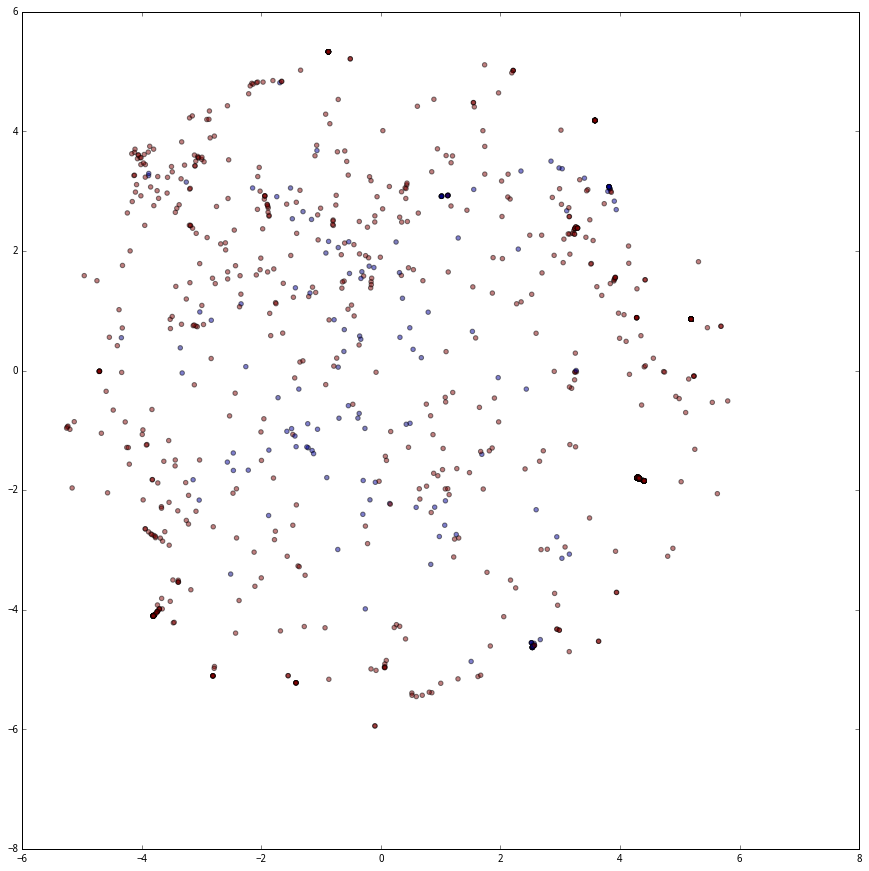

In [52]:
qq = [29, 4, 999]
plt.figure(figsize = (15,15))
plt.scatter(s[temp_te[temp_te['TripType'].isin(qq)].index,0], s[temp_te[temp_te['TripType'].isin(qq)].index,1], c=temp_te[temp_te['TripType'].isin(qq)].TripType, alpha=0.5, cmap='jet')
plt.show()

# Keras attempt

In [84]:
X_train = tr.drop(labels = ['VisitNumber', 'TripType'], axis = 1)
X_test = te.drop(labels = ['VisitNumber', 'TripType'], axis = 1)
Y_train = tr['TripType']
Y_test = te['TripType']

In [23]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(np.vstack([X_train.as_matrix(), X_test.as_matrix()]))
X_train = ss.transform(X_train.as_matrix())
X_test = ss.transform(X_test.as_matrix())

In [85]:
# X_train.to_pickle('./Data/X_train')
# X_test.to_pickle('./Data/X_test')
# Y_train.to_pickle('./Data/Y_train')
# Y_test.to_pickle('./Data/Y_test')

In [29]:
import pandas as pd
X_train = pd.read_pickle('./Data/X_train')
X_test = pd.read_pickle('./Data/X_test')
Y_train = pd.read_pickle('./Data/Y_train')
Y_test = pd.read_pickle('./Data/Y_test')

In [30]:
from sklearn.preprocessing import OneHotEncoder
Y_train = pd.get_dummies(Y_train, prefix = 'class')
Y_test = pd.get_dummies(Y_test, prefix = 'class')

In [49]:
from sklearn.metrics import log_loss
# from __future__ import absolute_import
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, Adam
# from . import backend as K
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(1024, input_dim=X_train.shape[1], init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(512, init='uniform', activation = 'sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(512, init='uniform', activation = 'sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(37, init='uniform', activation = 'sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
ada = Adagrad()
# model.compile(loss='mean_absolute_percentage_error', optimizer=sgd)
model.compile(loss='categorical_crossentropy', optimizer=ada)

# for i in range(10):
#     model.fit(X_train.as_matrix(), Y_train.as_matrix(), nb_epoch=1, batch_size = 128)
#     score_test = model.evaluate(X_test.as_matrix(), Y_test.as_matrix(), batch_size=128)
# #     pred_test = model.predict(X_test.as_matrix(), batch_size = 128)
# #     err = log_loss(pred_test.reshape([1,-1]), Y_test)
# #     err_test = log_loss(pred_test, Y_test)
#     print('Epoch {0}'.format(i))
#     print('Validation error: ', score_test)
#     score_train = model.evaluate(X_train.as_matrix(), Y_train.as_matrix(), batch_size=128)
# #     err_train = log_loss(pred_train, Y_train)
#     print('Train error: ', score_train)

In [3]:
import numpy as np

In [63]:
np.vstack([Y_train.as_matrix(), Y_test.as_matrix()]).shape

(94134, 38)

In [49]:
pred_test_ave

True

In [59]:
from sklearn.metrics import log_loss
pred_test_ave = True
num = 1
for i in range(num):
    print('Starting iteration {0}'.format(i+1))
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1]))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(37))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(np.vstack([X_train.as_matrix(), X_test.as_matrix()]),
              np.vstack([Y_train.as_matrix(), Y_test.as_matrix()]), nb_epoch=4, batch_size = 128, validation_split=0.3)

#     score_test = model.evaluate(X_test.as_matrix(), Y_test.as_matrix(), batch_size=128)
#     score_train = model.evaluate(X_train.as_matrix(), Y_train.as_matrix(), batch_size=128)
    pred_test = model.predict(X_test.as_matrix(), batch_size = 128)
    pred_train = model.predict(X_train.as_matrix(), batch_size = 128)
    #     err_train = log_loss(pred_train, Y_train)
    print('Train error: ', log_loss(Y_train, pred_train))
    print('Validation error: ', log_loss(Y_test, pred_test))
    if i==0:
        score_test_ave = pred_test.copy()/num
    else: 
        score_test_ave += pred_test/num
print('Average validation error: ', log_loss(Y_test, pred_test_ave))

Starting iteration 1


KeyboardInterrupt: 